# Capstone 3 - Pre-processing and modeling

Can we predict the electricity load for three cities of Panama, considering meteorologic conditions, holidays, and school schedule?

In [1]:
# Modules importation
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the dataset
data = pd.read_csv(r'C:\Users\laurence\OneDrive\Data Science\Capstone 3\capstone3_data_EDA.csv')
data.datetime = pd.to_datetime(data.datetime)
data = data.set_index("datetime")

In [3]:
# Droping the 2020 data, affected by the global pandemic.
data = data[(data['year'] != 2020)]

In [4]:
# Resampling on a weekly basis
data_uni_w = data['nat_elec_load'].resample("W").sum()
data_uni_w.drop(data_uni_w.tail(1).index,inplace=True)
data_uni_w.drop(data_uni_w.head(1).index,inplace=True)
data_uni_w = pd.DataFrame(data_uni_w)

In [5]:
# Visualization of end of the dataset to see the last entries
print(data_uni_w.head(3))
print(data_uni_w.tail(3))

            nat_elec_load
datetime                 
2015-01-11    181919.6224
2015-01-18    188082.3152
2015-01-25    179448.7184
            nat_elec_load
datetime                 
2019-12-15    220102.1454
2019-12-22    225592.3476
2019-12-29    206109.1895


<AxesSubplot:xlabel='datetime'>

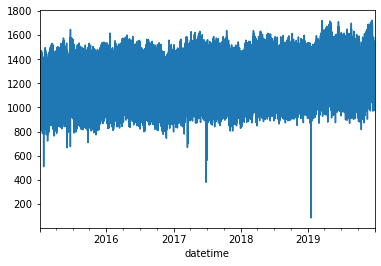

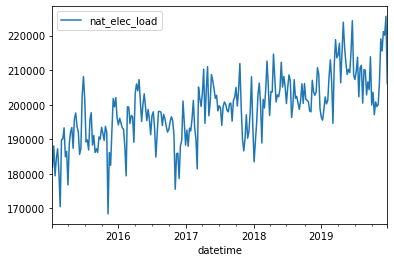

In [6]:
# Visualization of the original and the resampled data on a weekly basis.
data['nat_elec_load'].plot()
data_uni_w.plot()

<AxesSubplot:xlabel='datetime'>

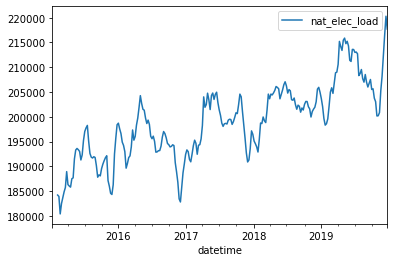

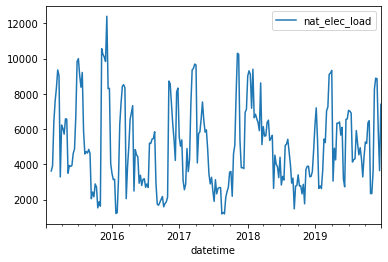

In [7]:
# Verification of the stationarity of the nat_elec_load feature
rolling_mean = data_uni_w.rolling(window = 5).mean()
rolling_std = data_uni_w.rolling(window = 5).std()

rolling_mean.plot()
rolling_std.plot()

The rolling standard deviation is flat, while there is an increase in the rolling mean.

In [8]:
# Augmented Dickey-Fuller test to verify stationarity
adfuller(data_uni_w)

(-2.3280140475257887,
 0.16309197981763768,
 5,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4926.952670738553)

The p value is over 0.05. The null hypothesis is not rejected, indicating that the data is considered as not stationary.

In [9]:
# Augmented Dickey-Fuller test to verify stationarity with one differenciation.
diff = data_uni_w["nat_elec_load"].diff().dropna()
adfuller(diff)

(-12.182456448733662,
 1.3418641029022053e-22,
 4,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4909.081673892859)

The p value is now below 0.05. The null hypothesis is then rejected, indicating that the data is now considered as stationary when there is one differenciation. The d parameter will hence have to be set to 1.

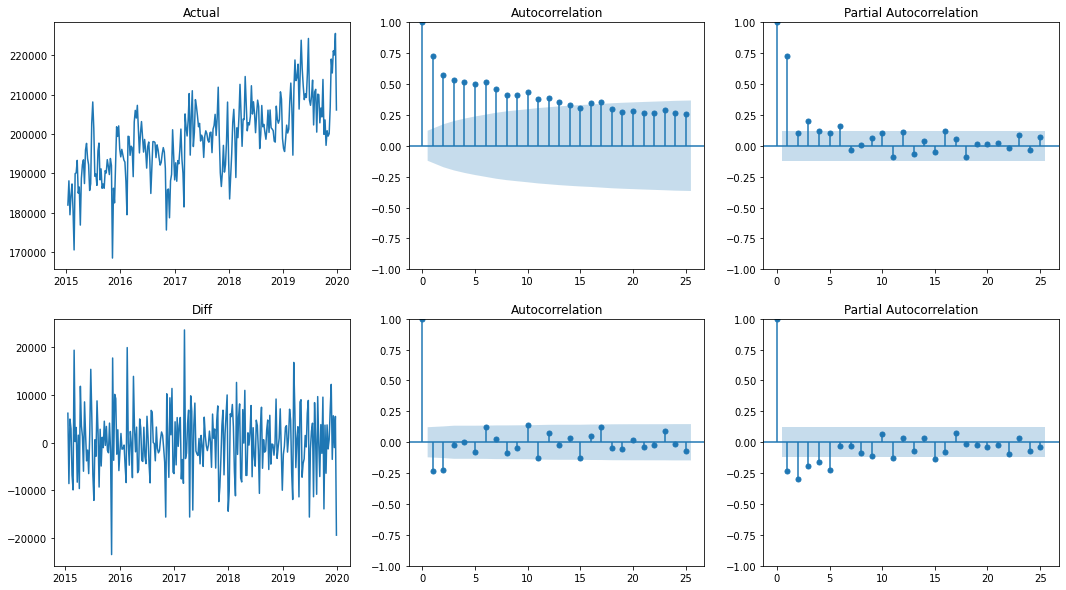

In [10]:
# Verification of the autocorrelation function and pqrtial autocorrelation function
fig, axes = plt.subplots(2, 3, figsize = (18,10))
axes[0,0].plot(data_uni_w); axes[0,0].set_title('Actual')
plot_acf(data_uni_w, ax=axes[0,1])
plot_pacf(data_uni_w, ax=axes[0,2])
axes[1,0].plot(data_uni_w.diff()); axes[1,0].set_title('Diff')
plot_acf(data_uni_w.diff().dropna(), ax=axes[1,1])
plot_pacf(data_uni_w.diff().dropna(), ax=axes[1,2])
plt.show()

In [11]:
# Train test split - test dataset corresponding to the 2019 year.
train_uni = data_uni_w[:207] 
test_uni = data_uni_w[207:]

## Univariate ARIMA model (auto-arima)

In [12]:
# Parameter tuning using stepwise_model
stepwise_model_uni = auto_arima(train_uni, start_p = 0, d = 1, start_q = 0, max_p = 10, max_d = 5, max_q = 5, start_P = 0,
                                D = 1, start_Q = 0, m = 12, seasonal = True, error_action = 'ignore', trace = True, 
                                suppress_warnings = True, stepwise = True, random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4086.869, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4062.739, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4050.688, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4084.303, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4040.508, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4060.539, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4042.507, Time=0.50 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4042.507, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4043.258, Time=0.32 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4052.000, Time=0.20 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4044.507, Time=0.53 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4036.830, Time=0.35 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4047.564, Time=0.22 sec
 ARIMA(1,1,1)(1,1,0)[12]

In [13]:
# Printing the Akaike information criterion 
aic_uni = stepwise_model_uni.aic()
aic_uni

4029.5534879845477

In [14]:
# Training data using the tuned model
stepwise_model_uni.fit(train_uni)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [15]:
# Making prediction for 2019
future_forecast_uni = stepwise_model_uni.predict(n_periods = 53)

results = pd.DataFrame()
results['future_forecast_uni'] = pd.DataFrame(future_forecast_uni, index = test_uni.index, columns = ['Prediction_uni'])

<AxesSubplot:xlabel='datetime'>

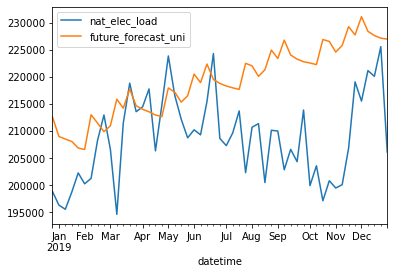

In [16]:
# Visualisation of the transformed real and predicted data
pd.concat([test_uni, results['future_forecast_uni']], axis = 1).plot()

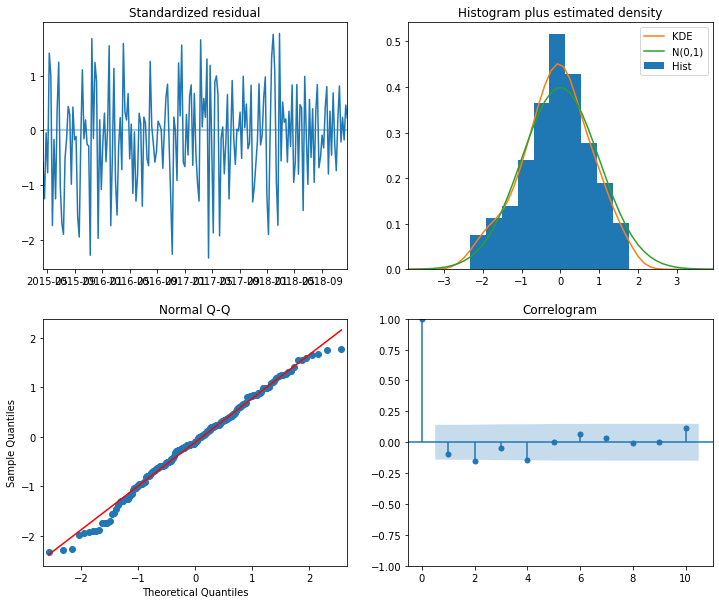

In [17]:
# Visualisation of the model diagnostic
stepwise_model_uni.plot_diagnostics(figsize=(12,10))
plt.show()

In [18]:
# Printing the model summary
print(stepwise_model_uni.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  207
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2009.777
Date:                              Sat, 25 Feb 2023   AIC                           4029.553
Time:                                      22:34:12   BIC                           4045.893
Sample:                                  01-11-2015   HQIC                          4036.170
                                       - 12-23-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0874      0.060     -1.468      0.142      -0.204       0.029
ar.L2         -0.15

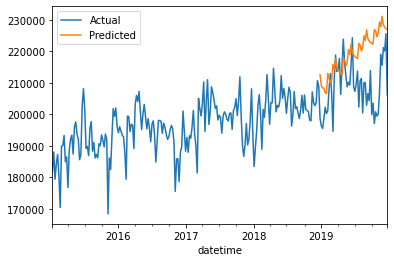

In [19]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_uni'].plot(label = 'Predicted')
plt.legend()

In [20]:
# Definition of a function to obtain metrics
def fc_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**0.5    
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse})

In [21]:
data2019 = data_uni_w['nat_elec_load'][207:]

acc_uni = fc_accuracy( results['future_forecast_uni'], data2019)
acc_uni

{'mape': 0.05475395266604876,
 'me': 10399.248436888047,
 'mae': 11219.234993264457,
 'mpe': 0.05102320989166766,
 'rmse': 13662.704624656117}

## Multivariate Arima model considering exogenous variables (auto-arima)

In [22]:
# Resampling on a weekly basis with the sum or the mean, depending on the feature
data_multi = pd.DataFrame()
data_multi['nat_elec_load'] = data['nat_elec_load'].resample("W").sum()
data_multi['t_toc'] = data['t_toc'].resample("W").mean()
data_multi['h_toc'] = data['h_toc'].resample("W").mean()
data_multi['p_toc'] = data['p_toc'].resample("W").sum()
data_multi['ws_toc'] = data['ws_toc'].resample("W").mean()
data_multi['t_san'] = data['t_san'].resample("W").mean()
data_multi['h_san'] = data['h_san'].resample("W").mean()
data_multi['p_san'] = data['p_san'].resample("W").sum()
data_multi['ws_san'] = data['ws_san'].resample("W").mean()
data_multi['t_dav'] = data['t_dav'].resample("W").mean()
data_multi['h_dav'] = data['h_dav'].resample("W").mean()
data_multi['p_dav'] = data['p_dav'].resample("W").sum()
data_multi['ws_dav'] = data['ws_dav'].resample("W").mean()
data_multi['holiday_ID'] = data['holiday_ID'].resample("W").sum()
data_multi['holiday'] = data['holiday'].resample("W").sum()
data_multi['school'] = data['school'].resample("W").sum()

data_multi.drop(data_multi.tail(1).index,inplace=True)
data_multi.drop(data_multi.head(1).index,inplace=True)
data_multi = pd.DataFrame(data_multi)

data_multi.head()

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-11,181919.6224,26.829882,0.017483,3.443329,25.429599,25.733156,0.016941,3.995602,13.844652,23.820581,0.015845,17.169937,6.687586,48.0,24.0,0.0
2015-01-18,188082.3152,27.047046,0.017778,7.872233,20.616549,26.108616,0.017291,11.167252,8.728468,24.394144,0.016080,20.262146,3.462595,0.0,0.0,0.0
2015-01-25,179448.7184,26.586434,0.016808,13.071503,18.210324,25.853082,0.016226,13.993546,8.015694,23.845967,0.015266,19.622757,3.004145,0.0,0.0,0.0
2015-02-01,184393.4256,27.024779,0.016309,5.475823,24.159216,26.246552,0.015350,6.404824,12.579642,23.686981,0.014966,15.239387,5.659424,0.0,0.0,0.0
2015-02-08,187290.1846,27.346896,0.017026,5.995931,20.208824,27.558020,0.016060,10.450697,9.342399,24.438553,0.015646,18.350250,3.755133,0.0,0.0,0.0


In [23]:
# Definition of a function to obtain the Dickey-Fuller test results for all features of the dataset.
def adfuller_test(series, signif=0.05):
    x = adfuller(series, autolag='AIC')
    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
    for key, val in x[4].items():
         output[f'Critical value {key}'] = val
    return pd.Series(output)

In [24]:
data_multi.apply(lambda x: adfuller_test(x), axis=0)

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
Test Statistic,-2.328014,-4.147768,-4.920268,-3.77971,-4.615757,-4.209354,-5.190418,-4.848723,-4.397102,-4.349681,-5.064249,-4.004139,-5.41961,-3.754414,-4.207352,-3.958252
P-value,0.163092,0.000807,0.000032,0.003122,0.000121,0.000635,0.000009,0.000044,0.0003,0.000364,0.000017,0.001389,0.000003,0.00341,0.00064,0.001646
Number of lags,5,2,9,2,8,0,7,8,2,0,7,2,2,6,6,16
Number of observations,254,257,250,257,251,259,252,251,257,259,252,257,257,253,253,243
Reject (signif. level 0.05),False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Critical value 1%,-3.45636,-3.456054,-3.456781,-3.456054,-3.456674,-3.455853,-3.456569,-3.456674,-3.456054,-3.455853,-3.456569,-3.456054,-3.456054,-3.456464,-3.456464,-3.457551
Critical value 5%,-2.872987,-2.872853,-2.873172,-2.872853,-2.873125,-2.872765,-2.873079,-2.873125,-2.872853,-2.872765,-2.873079,-2.872853,-2.872853,-2.873033,-2.873033,-2.873509
Critical value 10%,-2.57287,-2.572799,-2.572969,-2.572799,-2.572944,-2.572752,-2.572919,-2.572944,-2.572799,-2.572752,-2.572919,-2.572799,-2.572799,-2.572895,-2.572895,-2.573148


As seen before, nat_elec_load is not stationary, but it is the only one non-stationary feature of the dataset. We already know that one degree differenciation is enough to transform the data into stationary.

In [25]:
# Train test split - test dataset corresponding to the 2019 year.
train = data_multi["nat_elec_load"][1:207] 
test = data_multi["nat_elec_load"][207:]

exo_train = data_multi.drop("nat_elec_load", axis = 1)[1:207]
exo_test = data_multi.drop("nat_elec_load", axis = 1)[207:]

In [26]:
stepwise_model_multi_exo = auto_arima(train, exogenous = exo_train, start_p = 0, d = 1, start_q = 0, max_p = 10, max_d = 5,
                                      max_q = 5, start_P = 0, D = 1, start_Q = 0, m = 12, seasonal = True,
                                      error_action = 'ignore', trace = True, suppress_warnings = True, stepwise = True,
                                      random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4066.422, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4059.977, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4055.014, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4060.862, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4027.695, Time=0.61 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4025.739, Time=0.63 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4027.561, Time=1.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4025.570, Time=0.73 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4042.276, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4058.480, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4023.886, Time=0.99 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,1)(2,1,0)[12]          

In [27]:
# Printing the Akaike information criterion 
aic_multi_exo = stepwise_model_multi_exo.aic()
aic_multi_exo

4022.3402631882927

In [28]:
# Training data using the model
stepwise_model_multi_exo.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [29]:
# Making prediction for 2019
future_forecast_multi_exo = stepwise_model_multi_exo.predict(n_periods = 53, exogenous = exo_train)
results['future_forecast_multi_exo'] = pd.DataFrame(future_forecast_multi_exo, index = test_uni.index, columns = ['Prediction_multi_exo'])

<AxesSubplot:xlabel='datetime'>

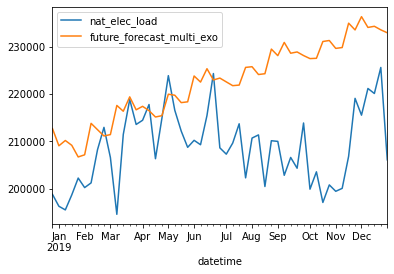

In [30]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['future_forecast_multi_exo']], axis = 1).plot()

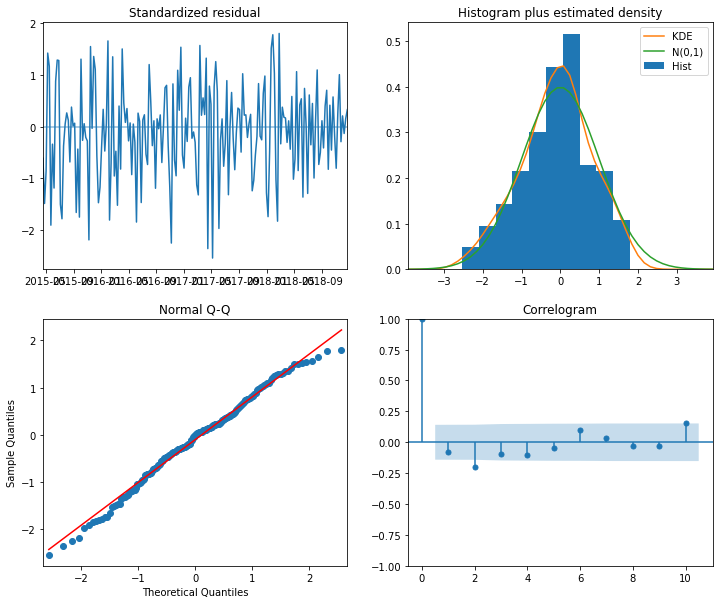

In [31]:
# Visualisation of the model diagnostic
stepwise_model_multi_exo.plot_diagnostics(figsize=(12,10))
plt.show()

In [32]:
# Printing the model summary
print(stepwise_model_multi_exo.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  206
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2005.170
Date:                              Sat, 25 Feb 2023   AIC                           4022.340
Time:                                      22:34:43   BIC                           4041.916
Sample:                                  01-18-2015   HQIC                          4030.268
                                       - 12-23-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1088      0.060     -1.801      0.072      -0.227       0.010
ar.L2         -0.08

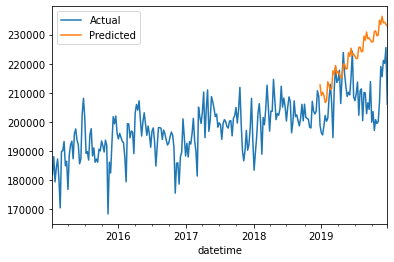

In [33]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_multi_exo'].plot(label = 'Predicted')
plt.legend()

In [34]:
acc_multi_exo = fc_accuracy(results['future_forecast_multi_exo'], data2019)
acc_multi_exo

{'mape': 0.06834910255080649,
 'me': 13731.825907665925,
 'mae': 14048.143341078036,
 'mpe': 0.06691477187031461,
 'rmse': 16782.40385734982}

## Multivariate Arima model (seasonal_index as the exogenous feature) (auto-arima)

In [35]:
# Obtaining the seasonal index
seasonal_dec = seasonal_decompose(x=data_uni_w['nat_elec_load'], model = 'additive', extrapolate_trend='freq')
seasonal_index = seasonal_dec.seasonal[207:].to_frame()

In [36]:
stepwise_model_multi_si = auto_arima(train, exogenous = seasonal_index, start_p = 0, d = 1, start_q = 0, max_p = 10,
                                     max_d = 5, max_q = 5, start_P = 0, D = 1, start_Q = 0, m = 12, seasonal = True, 
                                     error_action = 'ignore', trace = True, suppress_warnings = True, stepwise = True, 
                                     random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4066.422, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4059.977, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4055.014, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4060.862, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4027.695, Time=0.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4025.739, Time=0.73 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4027.561, Time=1.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4025.570, Time=0.72 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4042.276, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4058.480, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4023.886, Time=0.99 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(2,1,0)[12]          

In [37]:
# Printing the Akaike information criterion 
aic_multi_si = stepwise_model_multi_si.aic()
aic_multi_si

4022.3402631882927

In [38]:
# Training data using the model
stepwise_model_multi_si.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [39]:
# Making prediction for 2019
future_forecast_multi_si = stepwise_model_multi_si.predict(n_periods = 53, exogenous = seasonal_index)
results['future_forecast_multi_si'] = pd.DataFrame(future_forecast_multi_exo, index = test_uni.index, columns = ['Prediction_multi_exo'])

<AxesSubplot:>

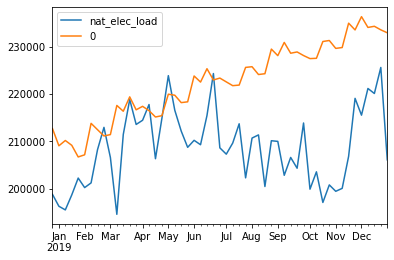

In [40]:
# Visualisation of the transformed real and predicted data
pd.concat([test, future_forecast_multi_si], axis = 1).plot()

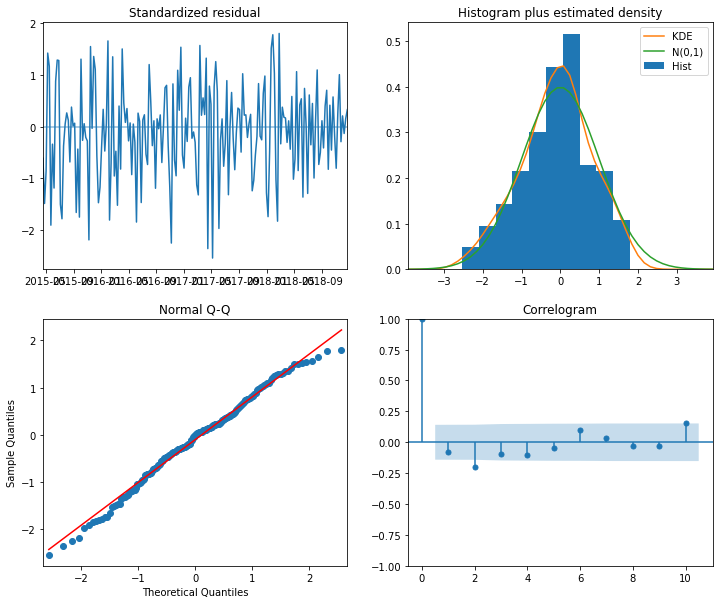

In [41]:
# Visualisation of the model diagnostic
stepwise_model_multi_si.plot_diagnostics(figsize=(12,10))
plt.show()

In [42]:
# Printing the model summary
print(stepwise_model_multi_si.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  206
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2005.170
Date:                              Sat, 25 Feb 2023   AIC                           4022.340
Time:                                      22:35:14   BIC                           4041.916
Sample:                                  01-18-2015   HQIC                          4030.268
                                       - 12-23-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1088      0.060     -1.801      0.072      -0.227       0.010
ar.L2         -0.08

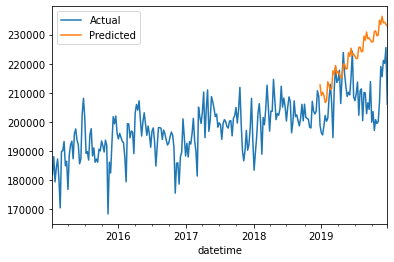

In [43]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_multi_si'].plot(label = 'Predicted')
plt.legend()

In [44]:
acc_multi_si = fc_accuracy(results['future_forecast_multi_si'], data2019)
acc_multi_si

{'mape': 0.06834910255080649,
 'me': 13731.825907665925,
 'mae': 14048.143341078036,
 'mpe': 0.06691477187031461,
 'rmse': 16782.40385734982}

## VAR model

In [45]:
# Initiating the VAR model using all available data and the differentiated target data
var_model = VAR(data_multi)

In [46]:
# Selecting the appropriate lag of the model
order = var_model.select_order()
order.summary()

,AIC,BIC,FPE,HQIC
0,-3.808,-3.580,0.02219,-3.716
1,-10.16,-6.289*,3.863e-05,-8.604
2,-10.05,-2.523,4.447e-05,-7.017
3,-9.776,1.396,6.194e-05,-5.277
4,-9.273,5.546,0.0001153,-3.306
5,-9.181,9.286,0.0001548,-1.745
6,-9.248,12.87,0.0001984,-0.3434
7,-9.283,16.48,0.0003051,1.090
8,-9.576,19.83,0.0004435,2.266
9,-9.641,23.42,0.001064,3.670


14 lags, showing the most minimum values, was selected for modeling.

In [47]:
# Fiting the model using 14 lags
var_results = var_model.fit(14)
var_results.summary()
lag_order = var_results.k_ar

In [48]:
# Making prediction for 2019
future_forecast_var = var_results.forecast(data_multi.values[-lag_order:], 53)
future_forecast_var = pd.DataFrame(future_forecast_var)
future_forecast_var.columns = ['nat_elec_load','t_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san', 'ws_san', 't_dav', 'h_dav',
                            'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school']
prediction_var = future_forecast_var['nat_elec_load']

In [49]:
date = ['2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17',
        '2019-02-24', '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
        '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02', '2019-06-09',
        '2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
        '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
        '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
        '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29']
date = pd.DataFrame(date, columns = ['datetime'])

In [50]:
prediction_var = pd.concat([date, prediction_var], axis = 1)
prediction_var.datetime = pd.to_datetime(prediction_var.datetime)
prediction_var = prediction_var.set_index("datetime")
prediction_var.columns = ['Prediction_var']

results['Prediction_var'] = prediction_var['Prediction_var']

<AxesSubplot:xlabel='datetime'>

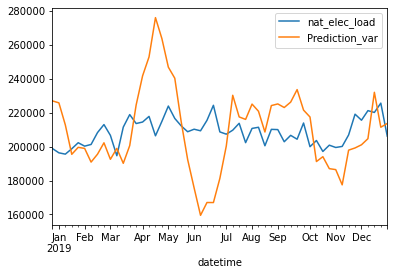

In [51]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['Prediction_var']], axis = 1).plot()

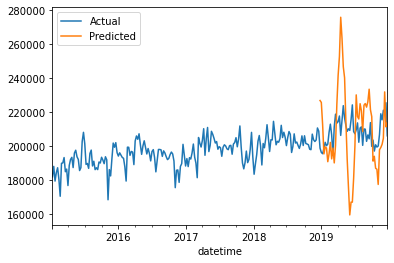

In [52]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['Prediction_var'].plot(label = 'Predicted')
plt.legend()

In [53]:
acc_var = fc_accuracy(results['Prediction_var'], data2019)
acc_var

{'mape': 0.090437995542275,
 'me': 1081.5557292234246,
 'mae': 18991.20372104175,
 'mpe': 0.005892830189855612,
 'rmse': 23763.63728559281}

## VAR model using less lag (n = 10)

In [54]:
# Fiting the model using 14 lags
var_results_10lags = var_model.fit(10)
var_results_10lags.summary()
lag_order_10lags = var_results_10lags.k_ar

In [55]:
# Making prediction for 2019
future_forecast_var10lags = var_results_10lags.forecast(data_multi.values[-lag_order:], 53)
future_forecast_var10lags = pd.DataFrame(future_forecast_var10lags)
future_forecast_var10lags.columns = ['nat_elec_load', 't_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san',
                                     'ws_san', 't_dav', 'h_dav', 'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school']
prediction_var10lags = future_forecast_var10lags['nat_elec_load']

In [56]:
prediction_var10lags = pd.concat([date, prediction_var10lags], axis = 1)
prediction_var10lags.datetime = pd.to_datetime(prediction_var10lags.datetime)
prediction_var10lags = prediction_var10lags.set_index("datetime")
prediction_var10lags.columns = ['Prediction_var10lags']

results['Prediction_var10lags'] = prediction_var10lags['Prediction_var10lags']

<AxesSubplot:xlabel='datetime'>

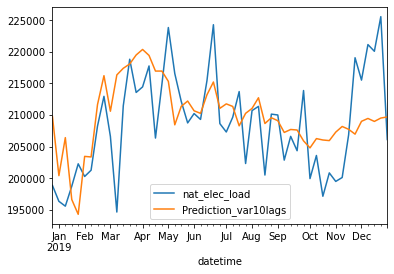

In [57]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['Prediction_var10lags']], axis = 1).plot()

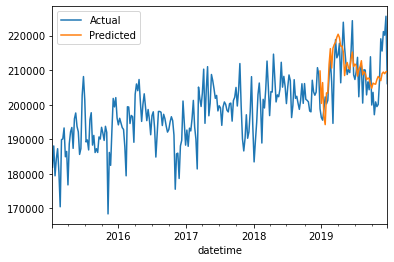

In [58]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['Prediction_var10lags'].plot(label = 'Predicted')
plt.legend()

In [59]:
acc_var10lags = fc_accuracy(results['Prediction_var10lags'], data2019)
acc_var10lags

{'mape': 0.026268200930049956,
 'me': 1238.7886743788692,
 'mae': 5469.683996496544,
 'mpe': 0.006866040266282146,
 'rmse': 6985.408553888574}

## Model review

In [60]:
# Combining all the accuracy results in a single data frame
acc_results = pd.DataFrame()
acc_results['metrics'] = ['mape', 'me', 'mae', 'mpe', 'rmse']
acc_results = acc_results.set_index('metrics')
acc_results['acc_uni'] = acc_uni.values()
acc_results['acc_multi_exo'] = acc_multi_exo.values()
acc_results['acc_multi_si'] = acc_multi_si.values()
acc_results['acc_var'] = acc_var.values()
acc_results['acc_var10lags'] = acc_var10lags.values()
acc_results

,acc_uni,acc_multi_exo,acc_multi_si,acc_var,acc_var10lags
metrics,,,,,
mape,0.054754,0.068349,0.068349,0.090438,0.026268
me,10399.248437,13731.825908,13731.825908,1081.555729,1238.788674
mae,11219.234993,14048.143341,14048.143341,18991.203721,5469.683996
mpe,0.051023,0.066915,0.066915,0.005893,0.006866
rmse,13662.704625,16782.403857,16782.403857,23763.637286,6985.408554


<AxesSubplot:xlabel='metrics'>

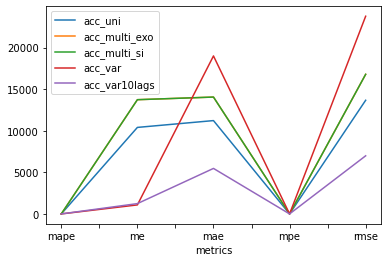

In [61]:
acc_results.plot()

In [62]:
print('aic_uni:', aic_uni)
print('aic_multi_exo:', aic_multi_exo)
print('aic_multi_si:', aic_multi_si)

aic_uni: 4029.5534879845477
aic_multi_exo: 4022.3402631882927
aic_multi_si: 4022.3402631882927


<AxesSubplot:xlabel='datetime'>

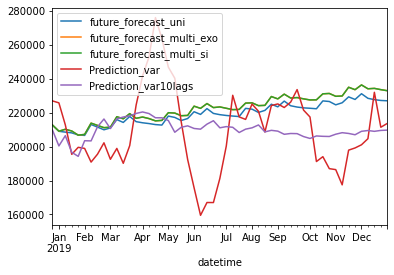

In [63]:
# Visualization of all the predictions
results.plot()

 ### Conclusions
- Both multivariable ARIMA models give exactly the same metrics and results. This could be linked to a very negligeable impact of the exogenous variables considered on target modeling, or this might also indicates a misapplication of the models.
- There is no pattern in the residual values when using both univariable and multivariables ARIMA.
- The KDE is mostly symmetrical in both univariable and multivariables ARIMA models, but with a little skew towards negative values.
- The BIC is a little lower for multivariable ARIMA models (4041.916) than for the univariable ARIMA (4045.893).
- The VAR model with the prescribed number of lags (n = 14) predict very noisy and not meaningful data, and seems very prone to overfitting. 
- The VAR using less lags (n = 10) give the best results, but is less accurate for the last part of the modeling. This may indicates that a prediction on a one year period could be to long.
- All ARIMA models give similar results, and tend to omit the more cyclic variations. The VAR model using 14 lag seems to overestimate the variability.
- In this context, the VAR using 10 lags is the best model.